# Single channel recordings

#### **Basic instructions:**
#### 1. **To run code windows/blocks:** 

    - you can either hit the play button to the left of the code window 

    - or you can use they keyboard shortcut: select the block and press 'shift-enter'.

#### 2. The first time you run this code notebook, you will get a popup asking to choose which version of Python to use (the python "kernel"). **Choose the python kernel called "CSHL_IonChannels"**

    - If you did it correctly, you should see "CSHL_IonChannels (Python 3.11.13)" in the top right of the screen.

#### 3. Make sure you data (.abf) files are in the "data" folder here on the left. You can just copy/paste the files from where they are saved on your computer.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from utils import *
update_plot_defaults()
%load_ext autoreload
%autoreload 2

## 1. Choose the data file you want to analyze

#### Put the .abf files with your recordings in the "data/Single_channels" folder

In [2]:
data_folder = "data/4-Single_channels"

from glob import glob
data_files = glob(data_folder+"/*.abf")
print(data_folder)
data_files

data/4-Single_channels


['data/4-Single_channels/mostafa_gap_free.abf',
 'data/4-Single_channels/2024_06_11_0003.abf',
 'data/4-Single_channels/2025_06_10_0028.abf',
 'data/4-Single_channels/2025_06_10_0052 KM002 gap free 2min.abf',
 'data/4-Single_channels/IV_mostafa.abf',
 'data/4-Single_channels/2025_06_10_0032.abf',
 'data/4-Single_channels/2025_06_10_0027.abf',
 'data/4-Single_channels/2025_06_10_0025.abf',
 'data/4-Single_channels/2025_06_10_0019.abf',
 'data/4-Single_channels/2025_06_10_0057.abf']

Choose which file you want to analyze and copy/paste the file name here:

**If you get an error, make sure you copy/pasted the name correctly (e.g. with both quotation marker, without any commas)**

In [3]:
data_file = 'data/4-Single_channels/2025_06_10_0052 KM002 gap free 2min.abf'
# data_file = 'data/4-Single_channels/2025_06_10_0028.abf'

Now we can load the file and plot the raw data:

Trace('2025_06_10_0052 KM002 gap free 2min.abf')
Data points: 6,000,000
Duration: 120.000 s
Sampling rate: 50000 Hz
Sampling interval: 0.020 ms
Available channels: Current, Voltage


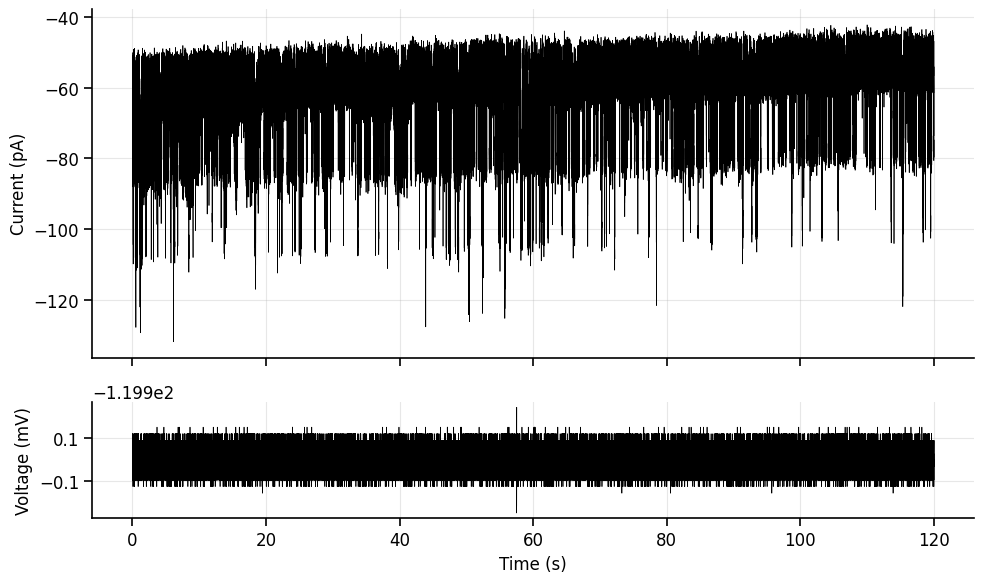

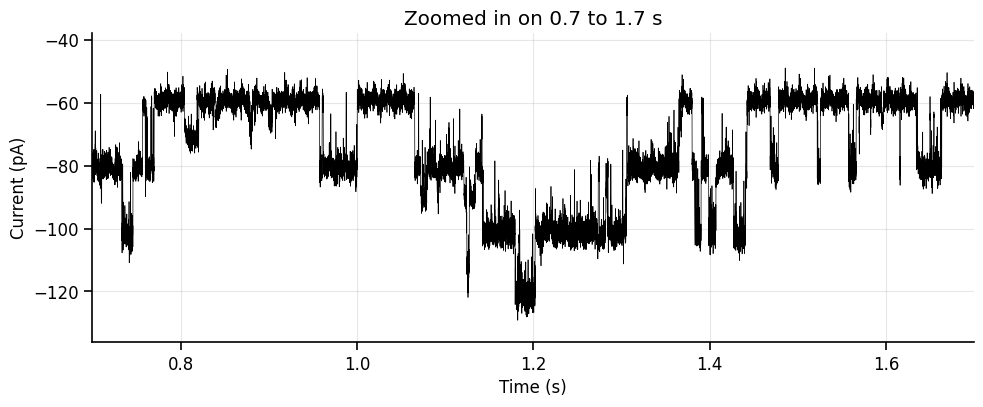

In [4]:
traces = Trace.from_axon_file(filename=data_file, 
                              load_voltage=True, 
                              load_ttl=True,
                              units=['pA', 'mV', 'V'], 
                              concatenate_sweeps=True)
print(traces)

time_units = 's' # specify seconds (s), or milliseconds (ms)
x_axis_range = (0.7,1.7) # Here you can set the rage of the x-axis to 'zoom in' on a specific part of the trace (1-2s recommended)

# ----------------------------------------------------------------------------------------------------------------
%matplotlib inline
ax = traces.plot(plot_voltage=True, sweep='all', time_units=time_units)
plt.show()
ax = traces.plot(plot_voltage=False, sweep='all', time_units=time_units)
ax.set_xlim(x_axis_range)
ax.set_title(f'Zoomed in on {x_axis_range[0]} to {x_axis_range[1]} {time_units}')
plt.show()

## 2. Signal processing

### Baseline the trace and apply highpass / lowpass / bandpass filtering

We want to measure the current amplitude relative to the baseline before the stimulus starts.  

Depending on you recording, you may also have 50/60 Hz line noise, high-frequency noise, or slow drift in your recording that we can correct for.

You can run this next cell as many times as you want to fine-tune the filtering parameters:

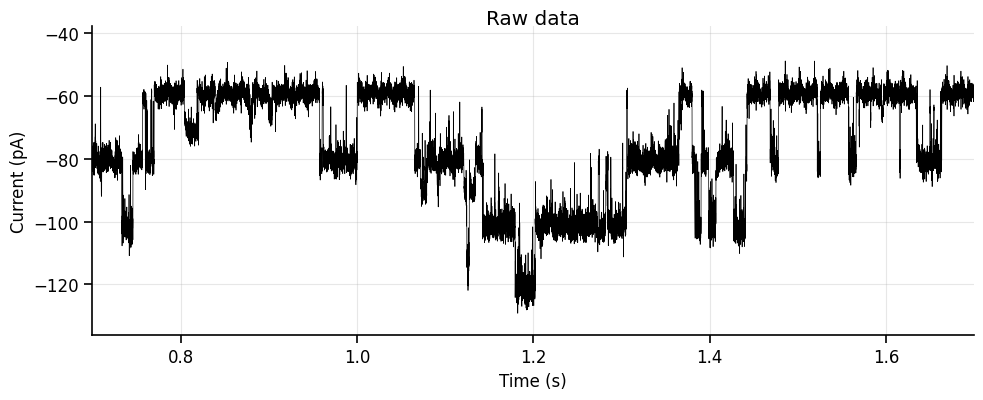

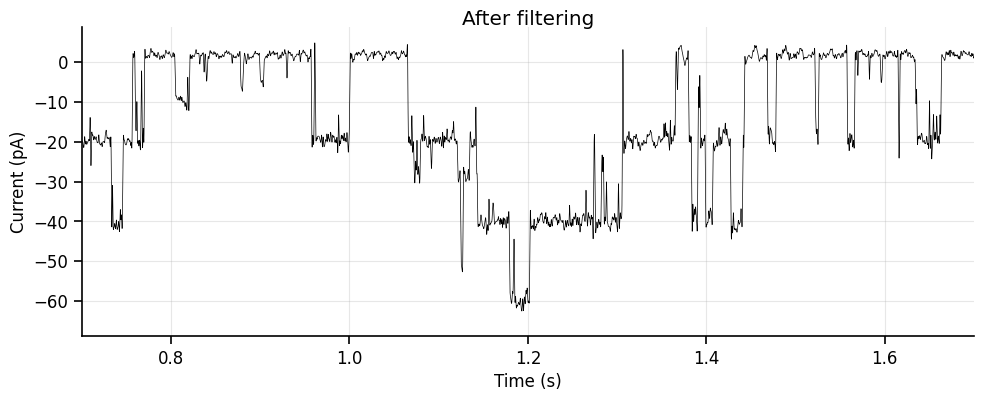

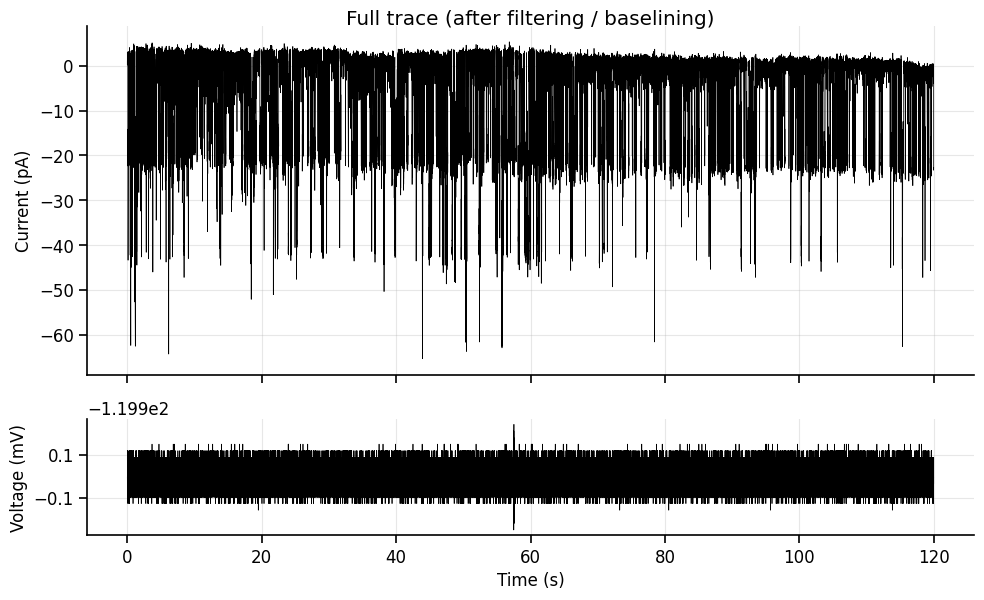

In [5]:
subtract_baseline = True    # Subtract baseline to measure the current relative to the baseline (just before the voltage step)

linear_detrending = True   # Detrend the data to remove linear or constant trends (e.g slow drift)
lowpass_filter    = True   # Lowpass filter (removes high-frequency noise)
bandpass_filter   = True   # Bandpass filter (removes 50/60 Hz mainline noise)


# ----------------------------------------------------------------------------------------------------------------
filtered_traces = traces.copy()
if linear_detrending:
    # Detrend the data to remove linear or constant trends (e.g slow drift)
    filtered_traces = filtered_traces.detrend(detrend_type='linear', num_segments=1, apply_to_voltage=False)

if lowpass_filter:
    # Lowpass filter (removes high-frequency noise)
    filtered_traces = filtered_traces.lowpass_filter(cutoff_freq = 700) # Choose a value in units of Hz
    
if bandpass_filter:
    # Bandpass filter (removes 50/60 Hz mainline noise)
    filtered_traces = filtered_traces.filter_line_noise(
        line_freq = 60, # Frequency (Hz) of noise to remove: 50 Hz (in Europe) or 60 Hz (in the US).
        width = 1, # Width (Hz) controls the width of frequency bands around the line frequency the filter cuts out.
        method = 'notch') # Options: 'notch' (IIR notch filter), 'bandstop' (Butterworth), or 'fft' (spectral).

if subtract_baseline:
    filtered_traces.current_data = filtered_traces.current_data - np.median(filtered_traces.current_data)

# Plot the traces before and after filtering
if any([linear_detrending, lowpass_filter, bandpass_filter, subtract_baseline]):
    # %matplotlib widget
    %matplotlib inline
    ax = traces.plot(plot_voltage=False, time_units=time_units, sweep='all')
    ax.set_xlim(x_axis_range)
    ax.set_title('Raw data', y=0.98)
    plt.show()
    ax = filtered_traces.plot(plot_voltage=False, time_units=time_units, sweep='all')
    ax.set_xlim(x_axis_range)
    ax.set_title('After filtering', y=0.98)
    plt.show()
    ax = filtered_traces.plot(plot_voltage=True, time_units=time_units, sweep='all')
    ax[0].set_title('Full trace (after filtering / baselining)', y=0.98)
    plt.show()


Once you are happy with the filter setting, run the next cell to implement them:

In [6]:
if any([linear_detrending, lowpass_filter, bandpass_filter, subtract_baseline]):
    print("Applied filtering and/or baseline subtraction to the traces.")
    traces = filtered_traces

Applied filtering and/or baseline subtraction to the traces.


### 2.1. Optional: crop trace (if the edges are not flat)

In [7]:
crop_traces = False

# The markers will define the window where we crop the traces. 'None'= No cropping.
marker_1 = None
marker_2 = None

# ----------------------------------------------------------------------------------------------------------------------
if crop_traces:
    %matplotlib inline
    ax = traces.plot(plot_voltage=False, time_units=time_units, marker_1=marker_1, marker_2=marker_2, sweep='all')
    plt.show()

In [8]:
# Apply the crop based on the markers
if crop_traces and (marker_1 is not None or marker_2 is not None):
    traces = traces.crop(timepoint=marker_1, time_units=time_units, timepoint_2=marker_2)
    ax = traces.plot(plot_voltage=False, time_units=time_units, marker_1=marker_1, marker_2=marker_2, sweep='all')
    plt.show()

### 3.3. Detect the number of distinct levels (channel opening states)

In [9]:
current_direction = 'inward' # Specify 'inward' or 'outward' current

Using provided mean guesses: [0, 20, 40, 60]
Fitted: mean=-0.915 pA, std=1.273 pA, R²=0.848
Fitted: mean=20.209 pA, std=1.423 pA, R²=0.928
Fitted: mean=40.490 pA, std=1.537 pA, R²=-0.092
Fitted: mean=59.869 pA, std=1.738 pA, R²=-0.183


/Users/ag1880/github-repos/CSHL_IonChannels2025/CSHL_IonChannels/utils.py:4339: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/Users/ag1880/.local/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


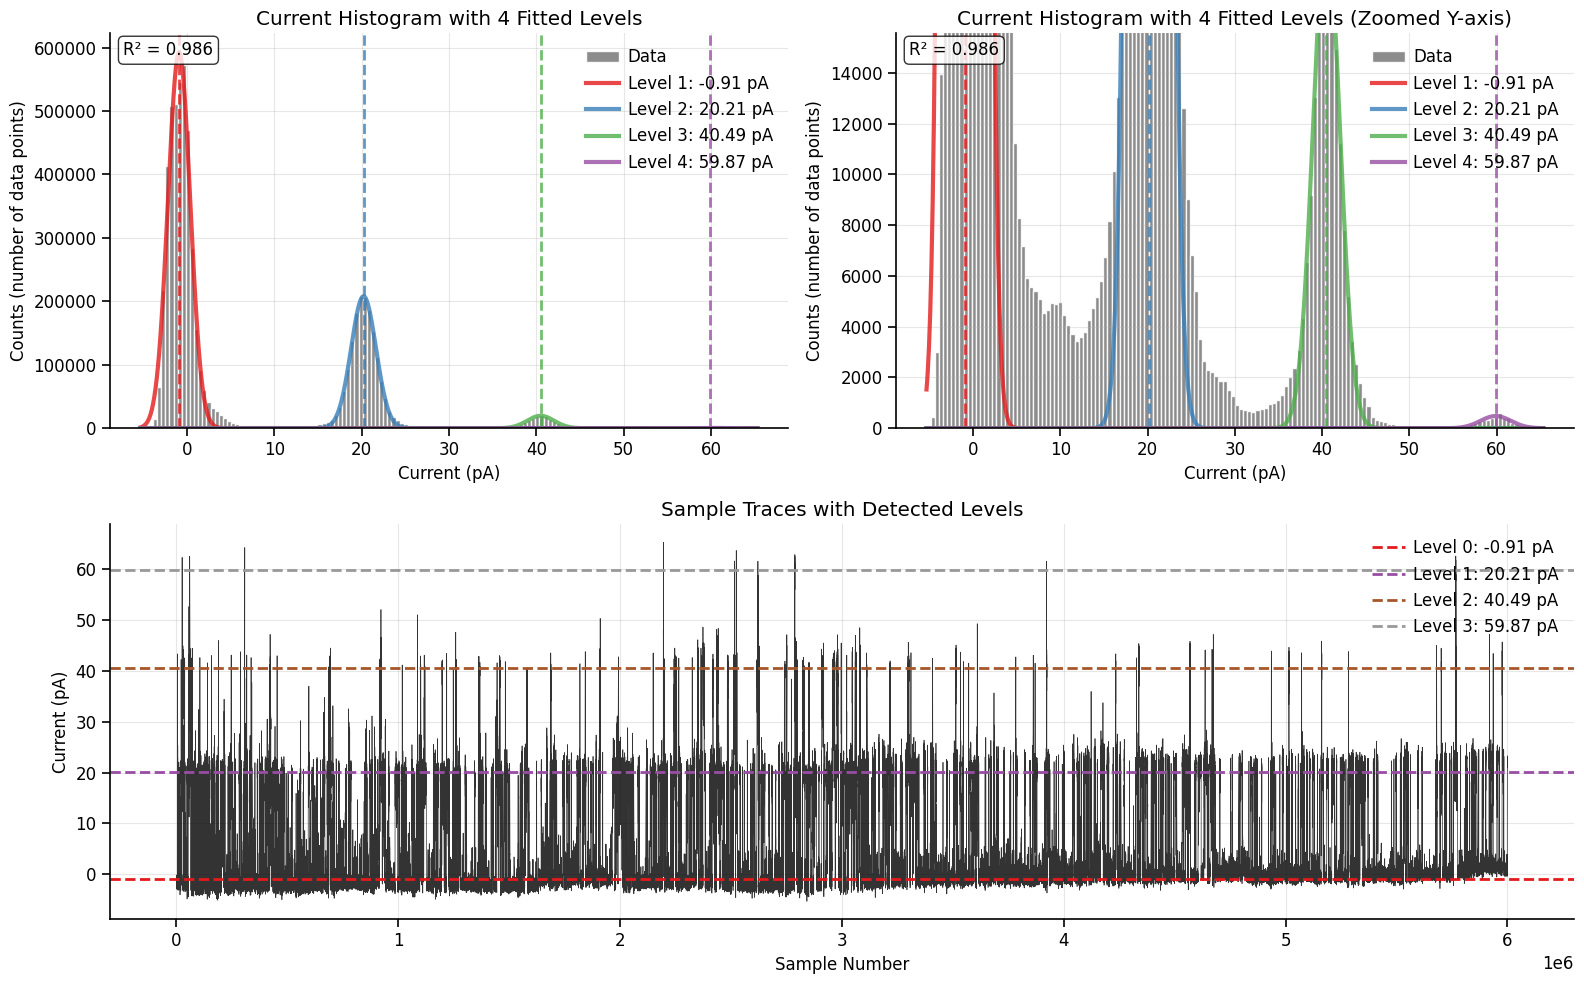


=== ITERATIVE LEVEL DETECTION RESULTS ===
Method: gaussian_subtraction (factor: 1.0)
Detected 4 current levels:
  Level 0: -0.915 pA
  Level 1: 20.209 pA
  Level 2: 40.490 pA
  Level 3: 59.869 pA


In [10]:
# Flip the trace (at the moment the idealization only works with positive levels)
if current_direction == 'inward':
    filtered_traces = -traces.current_data

# # Detect levels automatically by fitting Gaussian distributions to the histogram
%matplotlib inline
detected_levels = detect_levels_from_histogram(filtered_traces, 
                                            n_levels=4,  # Specify number of levels (baseline + open levels)
                                            mean_guesses=[0,20,40,60],  # Initial guesses for means
                                            bins=150)

#### Enter the value (pA) of each level for the trace idealization.

**Note:** the automatic gaussian fit usually fails to detect the highest level correctly, so look at the trace closely to choose the value manually.

(it's probably a multiple of the previous level)


In [11]:
# detected_levels = [-0.173, 10.127, 20.2]
# detected_levels = [-1.8, 20, 40, 60]

### Enter the driving force here to estimate the single channel conductance based on the single-level channel current


In [12]:
current = detected_levels[1]
voltage = np.abs(np.mean(traces.voltage_data)) # You might need to modify this if you were in cell-attached mode, since the driving force is not the same as the holding voltage

# For example, you could estimate the driving force from the holding voltage and the resting potential of the cell
# voltage = 120 

single_channel_conductance = current / voltage
from IPython.display import display, Math
display(Math(r"\text{Single channel conductance:}"))
display(Math(rf"\frac{{{current:.2f}\ \mathrm{{pA}}}}{{{voltage:.1f}\ \mathrm{{mV}}}} = {single_channel_conductance:.2f}\ \mathrm{{nS}}"))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [13]:
# Initialize detector with your filtered traces
detector = MultiLevelEventDetector(filtered_traces, traces.time, traces.sampling_rate)

detector.set_current_levels(detected_levels)

Set 4 current levels:
  Baseline: -0.91 pA
  L1: 20.21 pA
  L2: 40.49 pA
  L3: 59.87 pA
Detection thresholds: ['9.65', '30.35', '50.18'] pA


### 3.4. Detect channel open/close events and idealize single-channel behavior

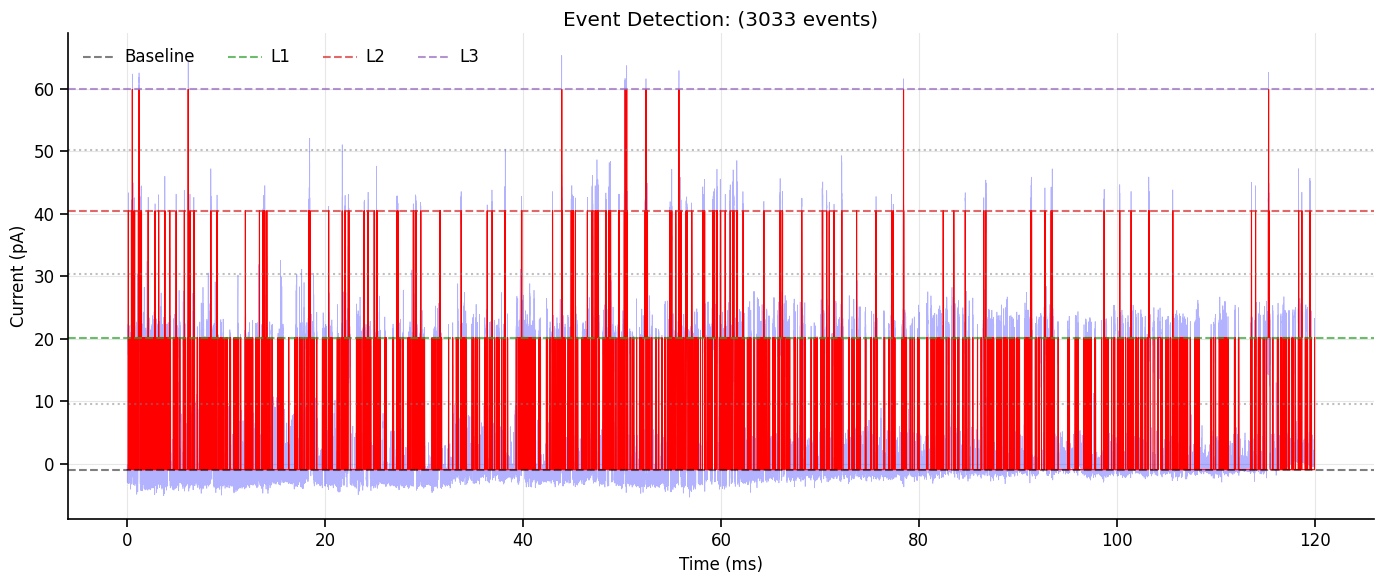

In [14]:
# Set detection parameters
detector.min_event_duration = 0.3  # ms - adjust based on your channel kinetics
detector.hysteresis_factor = 0.25  # This reduces the chance of flipping states when there are rapid small fluctuations close to the threshold

%matplotlib inline
events, idealized_trace = detector.detect_events(plot_result=True)

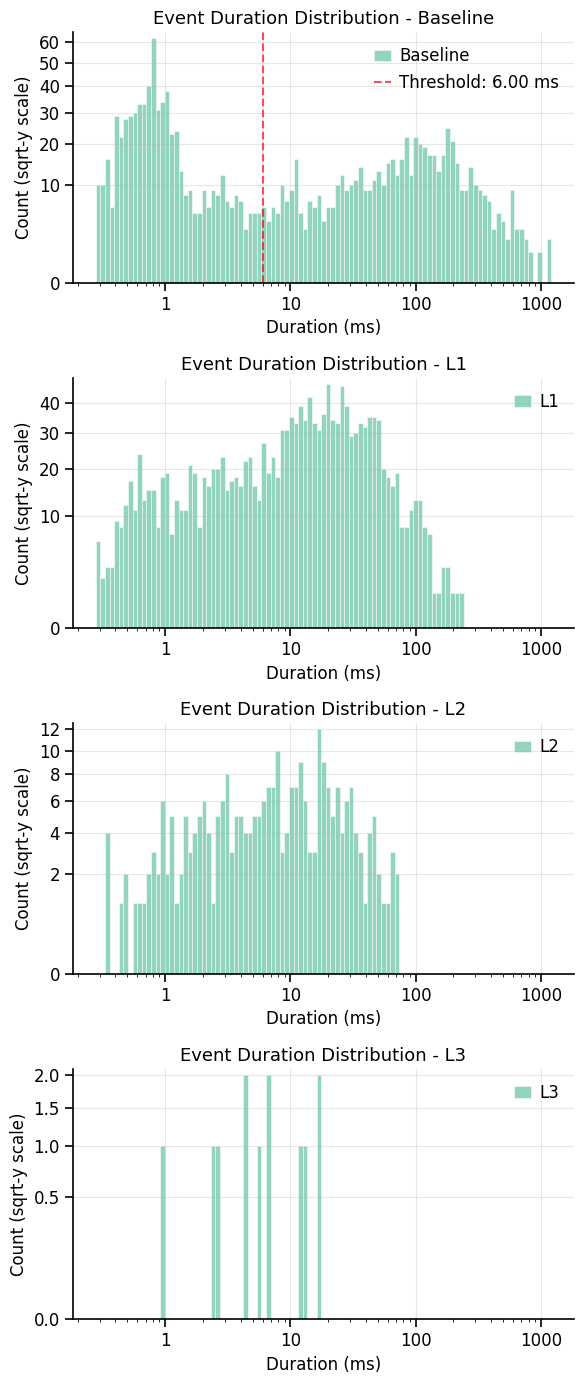

In [15]:
# Based on the histogram of closed durations, determine a threshold for burst separation
closed_threshold = 6  # ms - adjust based on your histogram

%matplotlib inline
durations = detector.plot_duration_histogram(bins=100, threshold=closed_threshold,
                                             fit_gaussian=True,
                                             log_x=True, sqrt_y_scale=True, separate_plots=True)

Burst Analysis (threshold: 6 ms)
Number of bursts: 601
Mean burst duration: 63.19 ms
Mean Po within bursts: 0.9675


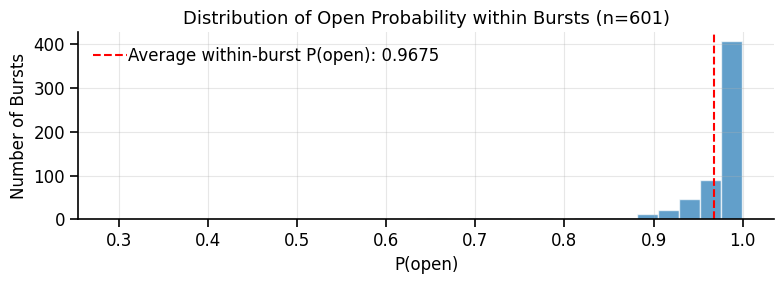

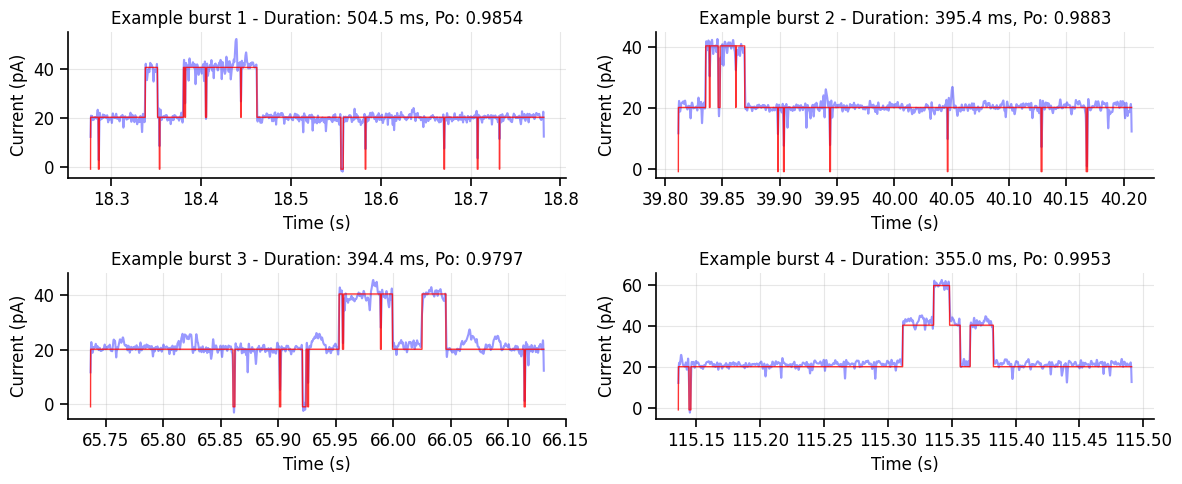

In [16]:
# Analyze the open probability within an activity burst
burst_data, burst_summary = detector.analyze_bursts(closed_threshold)

%matplotlib inline
detector.plot_burst_analysis(burst_data)

In [17]:
po_by_level, statistics = detector.calculate_level_probability(method='time_based')
detector.generate_analysis_report()

SINGLE-CHANNEL ANALYSIS REPORT

BASIC STATISTICS:
  Total events detected: 3033

CURRENT LEVELS:
  Baseline: -0.915 pA
  L1: 20.209 pA
  L2: 40.490 pA
  L3: 59.869 pA

LEVEL PROBABILITIES:
  Baseline: 0.6898 (68.979%)
  L1: 0.2802 (28.023%)
  L2: 0.0292 (2.921%)
  L3: 0.0008 (0.078%)

RECORDING TIME:
  Total: 120.000 s
  Baseline: 82.775 s
  L1: 33.627 s
  L2: 3.505 s
  L3: 0.093 s

EVENT DURATIONS:
  Baseline: 67.06 ± 128.12 ms (median: 4.88 ms, n=1234)
  L1: 22.09 ± 27.90 ms (median: 12.56 ms, n=1521)
  L2: 13.16 ± 14.45 ms (median: 7.66 ms, n=266)
  L3: 7.75 ± 5.38 ms (median: 6.04 ms, n=12)


## Calculate P(open) based on binomial distribution

If we have a good recording, we might be able to confidently say exactly how many channels are in our patch (from the largest open conductance level we see in the current trace). 

For example, there might be exactly 3 discrete conductance levels above baseline, consistent with 1, 2, or 3 BK channels being open. 

If we make a few assumptions, we can use the binomial theorem to calculate the P(open) for a single channel based on the amount of time spend in each conductance level. 

Assuming:
- All channels are identical,
- Each channel is **either open or closed** (no partial conductance states / sublevels)
- Channels behave **independently**
- The system is stationary / at steady state

We can model the number of open channels as a **binomial distribution**:

$$ P(k) = \binom{3}{k} p^k (1 - p)^{3 - k} = \frac{3!}{k!(3-k)!} p^k (1 - p)^{3 - k} $$

where:
- $P(k)$ is the probability of observing $k$ channels open
- $p$ is the open probability of a single channel
- $3$ is the total number of channels (maximum conductance level observed)

By plugging in different values for $k$ from 0 to 3, we get the expected occupancy of each conductance level:
- $ P(0) = (1 - p)^3 $
- $ P(1) = 3p(1 - p)^2 $
- $ P(2) = 3p^2(1 - p) $
- $ P(3) = p^3 $


Now we just need to fit our empirical data to these equations to estimate the single-channel open probability $p$.

We can set this up as a least-squares optimization problem (estimating $p$ by minimizing the squared error between the observed and expected probabilities, and finding the value of $p$ that minimizes the error):

$$ \text{error}(p) = \sum_{k=0}^{3} \left[ \hat{P}(k) - \binom{3}{k} p^k (1 - p)^{3 - k} \right]^2 $$

In [18]:
print(po_by_level)

{'Baseline': 0.6897925, 'L1': 0.28022583333333334, 'L2': 0.029205000000000002, 'L3': 0.0007766666666666668}


### Enter the total number of channels (based on max conductance level observed)


In [19]:
num_channels = 4

P_obs = np.array([val for val in po_by_level.values()]) # Proportion of time spent in each state/level
p_estimate, residuals = estimate_p_open(P_obs, num_channels)
print_p_open_results(p_estimate, residuals, P_obs, num_channels)

SINGLE-CHANNEL P(OPEN) ESTIMATION
Number of channels: 4
** Estimated instantaneous P(open): 0.0898 **

FIT QUALITY:
------------------------------
State | Observed | Predicted | Residual
------------------------------
   0  |  0.6898  |   0.6862  |   0.0036
   1  |  0.2802  |   0.2709  |   0.0093
   2  |  0.0292  |   0.0401  |  -0.0109
   3  |  0.0008  |   0.0026  |  -0.0019
------------------------------
Residual sum of squares: 0.000221
Root mean square error:  0.007439

INTERPRETATION:
------------------------------
• P(open) is the instantaneous probability that any single channel is open
  at any given moment in time
• Residuals show how well the binomial model fits your data
  (Small residuals indicate good agreement)


## Fit a Hidden Markov Model to estimate the channel switching behavior